In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

import pretty_confusion_matrix as pcm

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --------------Parameters-------------------
embedding_dim = 3
k_fold = 5
cross_validation = False
num_epoch=10
batch_size=512
feature_selection = True
num_genes = 36601
# --------------Plotting---------------------
plot_loss = True
plot_embedding_space = True
plot_confusion_matrix = True

In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(num_genes, 512)
        # Second fully connected layer that outputs our 10 labels
        self.drop1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(512, embedding_dim)
        self.cuda()

    def forward(self, x):
      x = self.fc1(x)
      x = F.relu(x)
      x = self.drop1(x)
      x = self.fc2(x)

      return x


class PL(nn.Module):
    def __init__(self, centers):
        super(PL, self).__init__()
        self.centers = centers

    def forward(self, mapping, labels):
        targets = torch.index_select(self.centers, 0, labels)
        dist = torch.norm(mapping - targets, dim=1)
        # print(dist[0])
        dist = torch.sum(dist)
        return dist/mapping.shape[0]

class I2CS(nn.Module):
    def __init__(self, centers):
        super(I2CS, self).__init__()
        self.centers = centers

    def forward(self, mapping, labels):
        sum_intra = torch.Tensor(0)
        sum_inter = torch.Tensor(0)
        for i in range(len(self.centers)):
            mask = labels == i
            ind = torch.nonzero(mask)
            list_one_type = mapping[ind]
            dist = torch.dist(list_one_type - self.centers[i])
            avg = torch.mean(torch.sum(dist))
            sum_intra += avg
        for i in range(len(self.centers)):
            dists = torch.dist(self.centers[i] - self.centers)
            min_dist = torch.min(dists)
            sum_inter+= min_dist
        return sum_intra/sum_inter

# class PL_Inter(nn.Module):
#     def __init__(self, centers):
#         super(PL_Inter, self).__init__()
#         self.centers = centers

#     def forward(self):
#         targets = torch.index_select(self.centers, 0, labels)
#         dist = torch.norm(mapping - targets, dim=1)
#         # print(dist[0])
#         dist = torch.sum(dist)
#         return dist/mapping.shape[0]

# class PL_Norm(nn.Module):
#     def __init__(self, centers):
#         super(PL_Norm, self).__init__()
#         self.centers = centers
#         self.dists = []
#         for center in centers:
#             self.dists.append(multivariate_normal.MultivariateNormal(loc=center.detach().cpu(), covariance_matrix=torch.eye(embedding_dim).detach().cpu()))

#     def forward(self, mapping, label):
#         sum = 0
#         # max = 0
#         for i, x in enumerate(mapping):
#             likelihood = torch.exp(self.dists[label[i]].log_prob(x.detach().cpu()))
#             # max_likelihood = torch.exp(self.dists[label[i]].log_prob(self.centers[label[i]].detach().cpu()))
#             # max+=max_likelihood
#             sum+=likelihood
#         return -sum/mapping.shape[0]

def create_model(D_metric=None, cuda=1):
  device = 'cuda' if cuda else 'cpu'
  D_metric = D_metric.cuda() if cuda and D_metric is not None else D_metric
  model_embedding = SimpleNN() 
  model = prototypical_network.LearntPrototypes(model_embedding, n_prototypes= D_metric.shape[0],
                                prototypes=None, embedding_dim=embedding_dim, device=device)
  return model.cuda()


In [4]:
D = pd.read_csv('C:/Users/xbh04/Desktop/distance_matrix_bcell_ABCs.csv').iloc[:, 1:]
D = torch.tensor(D.values, dtype=float)
dataset = sc.read_h5ad("C:/Users/xbh04/Desktop/b-cells.h5ad")
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'MNP/B doublets']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'T/B doublets']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'ABCs']
dataset_Pro_B = dataset[dataset.obs['Manually_curated_celltype'] == 'Pro-B']
dataset = dataset[dataset.obs['Manually_curated_celltype'] != 'Pro-B']
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}

In [5]:
# Train test split & Cross-validation
indices_by_celltypes = {}
train_indices, test_indices, cv = [], [], []
for cell_type in dataset.obs['Manually_curated_celltype'].unique():
    indices = np.where(dataset.obs['Manually_curated_celltype'] == cell_type)[0]
    np.random.shuffle(indices)
    indices_by_celltypes.update({cell_type: indices})
    split = int(len(indices)/k_fold)
    if cross_validation:
        for i in range(k_fold):
            temp = i*split
            temp_test = list(indices[temp:temp+split])
            temp_train = list(set(indices) - set(temp_test))
            if cell_type != dataset.obs['Manually_curated_celltype'].unique()[0]:
                cv[i].get("train").extend(temp_train)
                cv[i].get("test").extend(temp_test)
            else:
                cv.append({"train":temp_train, "test": temp_test})
    else:
        test_indices.extend(indices[:split])
        train_indices.extend(indices[split:])

In [6]:
# Feature Selection by Scanpy
def select_features(dataset_training):
    print("feature_selection")
    dataset_training.var['mt'] = dataset_training.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(dataset_training, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc_pp_train = sc.pp.filter_cells(dataset_training, min_genes=200, copy=True)
    sc.pp.filter_genes(sc_pp_train, min_cells=3)
    sc_pp_train = sc_pp_train[sc_pp_train.obs.n_genes_by_counts < 2500, :]
    sc_pp_train = sc_pp_train[sc_pp_train.obs.pct_counts_mt < 5, :]
    sc.pp.highly_variable_genes(sc_pp_train, n_top_genes=int(num_genes/4))
    sc_pp_train = sc_pp_train[:, sc_pp_train.var.highly_variable]
    return sc_pp_train

In [7]:
def train_nn(l_metric=2, l_pl = 2, epochs = num_epoch, D_metric=None, D_cost=D, cuda=1):
    D_metric = D_metric.cuda()
    model = create_model(D_metric, cuda)      
    dl_train = dataloader_training
    dl_test = dataloader_testing
    
    delta = DistortionLoss(D_metric)
    criterion = nn.CrossEntropyLoss()
    ac = cost.AverageCost(D_cost)

    opt = torch.optim.AdamW(model.parameters())
    # log = {}
    if plot_loss:
        loss_xe = []
        loss_disto = []
        loss_pl = []
    if plot_embedding_space:
        training_embeddings = []
        training_labels = []
        testing_embeddings = []
        testing_pred_labels = []
        testing_true_labels = []
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()

        model.train()
        t0 = time.time()
        if plot_loss:
            batch_xe = []
            batch_disto = []
            batch_pl = []
        for batch in dl_train:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            out, embeddings = model(x)
            opt.zero_grad()
            pl_loss = PL(centers = model.prototypes.data)
            i2cs = I2CS(centers = model.prototypes.data)
            pl_loss_ = pl_loss(embeddings, y)
            i2cs_loss_ = i2cs(embeddings, y)
            print(i2cs_loss_)
            if epoch == epochs and plot_embedding_space:
                training_embeddings.extend(embeddings)
                training_labels.extend(y)
            # loss = criterion(out, y)  + l_pl*pl_loss_
            loss = criterion(out, y) +  l_metric * delta(model.prototypes) + l_pl*pl_loss_
            
            if plot_loss:
                batch_xe.append(criterion(out, y).detach().cpu())
                batch_disto.append((l_metric * delta(model.prototypes)).detach().cpu())
                batch_pl.append(l_pl*pl_loss_.detach().cpu())

            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
            AC_meter.add(ac(pred.cpu(),y.cpu()))
        
        if plot_loss:
            loss_xe.append(np.array(batch_xe).mean())
            loss_disto.append(np.array(batch_disto).mean())
            loss_pl.append(np.array(batch_pl).mean())
            
        t1 = time.time()
        # log[epoch] = {'train_ER':ER_meter.value()[0], 'train_AC':AC_meter.value()[0], 'train_time':t1-t0}
        
        print('Train ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()
        t0 = time.time()
        for batch in dl_test:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            with torch.no_grad():
                out, embedding_y = model(x)
            pred = out.detach()
            # pred = out
            if epoch == epochs and plot_embedding_space:
                testing_embeddings.extend(embedding_y)
                testing_pred_labels.extend(pred.cpu().numpy())
                testing_true_labels.extend(y)
            ER_meter.add(pred.cpu(),y)
            AC_meter.add(ac(pred.cpu(),y))
        t1 = time.time()
        print('Test ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))
        # log[epoch].update({'test_ER':ER_meter.value()[0], 'test_AC':AC_meter.value()[0], 'test_time':t1-t0})
        results = {}
        results['model'] = model
        if plot_loss:
            results['loss_xe'] = loss_xe
            results['loss_disto'] = loss_disto
            results['loss_pl'] = loss_pl
        if plot_embedding_space:
            results['training_embeddings'] = training_embeddings
            results['training_labels'] = training_labels
            results['test_embeddings'] = testing_embeddings
            results['test_true_labels'] = testing_true_labels
            results['test_pred_labels'] = testing_pred_labels
    return results

In [8]:
# if cross_validation:
#     results_list = []
#     for fold in range(k_fold):
#         print(f'FOLD {fold}')
#         print('--------------------------------')
#         if feature_selection:
#             train_dataset = select_features(train_dataset)
#             test_dataset = test_dataset[:,train_dataset.var_names]
#             num_genes = len(train_dataset.var_names)
#         # Define data loaders for training and testing data in this fold

#         train_subsampler = torch.utils.data.SubsetRandomSampler(cv[fold]['train'])
#         test_subsampler = torch.utils.data.SubsetRandomSampler(cv[fold]['test'])
#         dataloader_training = AnnLoader(train_dataset, batch_size=batch_size, convert=encoders, sampler=train_subsampler)
#         dataloader_testing = AnnLoader(test_dataset, batch_size=batch_size, convert=encoders, sampler=test_subsampler)

#         results = train_nn(D_metric=D, l_metric=1)
#         results_list.append(results)
# else:
    
#     if feature_selection:
#         train_dataset = dataset[train_indices]
#         train_dataset = select_features(train_dataset)
#         dataset = dataset[:,train_dataset.var_names]
#         num_genes = len(train_dataset.var_names)
        
#     # Define data loaders for training and testing data in this fold
#     dataloader_training = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=train_indices)
#     dataloader_testing = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=test_indices)

#     results = train_nn(D_metric=D, l_metric=1)

In [11]:
kfold = KFold(n_splits=k_fold, shuffle=True)
# Start print
print('--------------------------------')
model_list = []

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
      # Print
      print(f'FOLD {fold}')
      print('--------------------------------')

      # Sample elements randomly from a given list of ids, no replacement.
      train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
      test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
      if feature_selection:
            train_dataset = dataset[train_indices]
            train_dataset = select_features(train_dataset)
            dataset = dataset[:,train_dataset.var_names]
            num_genes = len(train_dataset.var_names)
      # Define data loaders for training and testing data in this fold
            
      sc.pp.normalize_total(dataset, target_sum = 1e4)
      sc.pp.log1p(dataset)
      dataloader_training = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=train_subsampler)
      dataloader_testing = AnnLoader(dataset, batch_size=batch_size, convert=encoders, sampler=test_subsampler)

      results = train_nn(D_metric=D, l_metric=1)
      model_list.append(results)
      
      if not cross_validation:
            break

--------------------------------
FOLD 0
--------------------------------
feature_selection


C:\Users\xbh04\AppData\Local\Temp\ipykernel_9224\4160726366.py:4: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  dataset_training.var['mt'] = dataset_training.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Epoch 1


RuntimeError: The size of tensor a (512) must match the size of tensor b (0) at non-singleton dimension 0

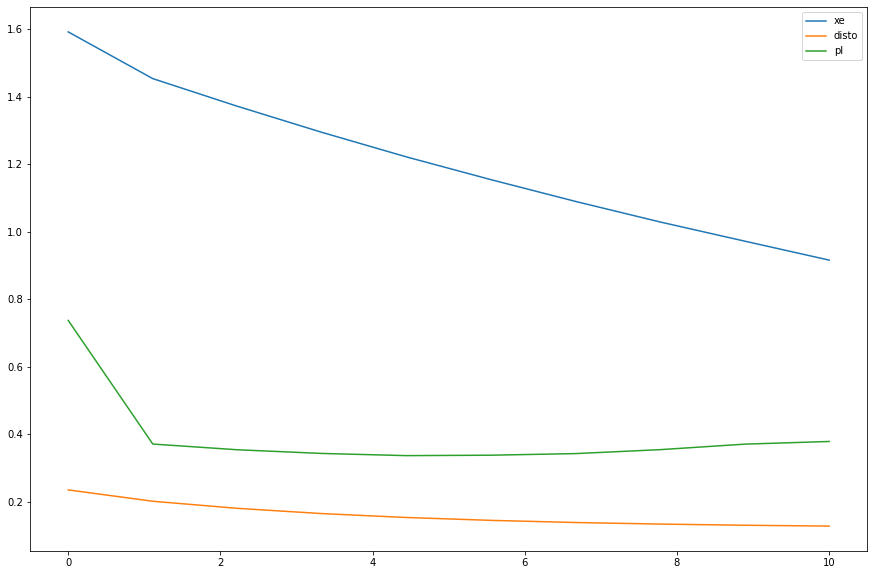

In [ ]:
if plot_loss:
    plt.figure(figsize=(15, 10))
    ax = plt.axes()

    x = np.linspace(0, len(results.get('loss_pl')), len(results.get('loss_pl')))
    plt.plot(x, np.array(results.get('loss_xe')), label='xe')
    plt.plot(x, np.array(results.get('loss_disto')), label='disto')
    plt.plot(x, np.array(results.get('loss_pl')), label='pl')
    plt.legend()

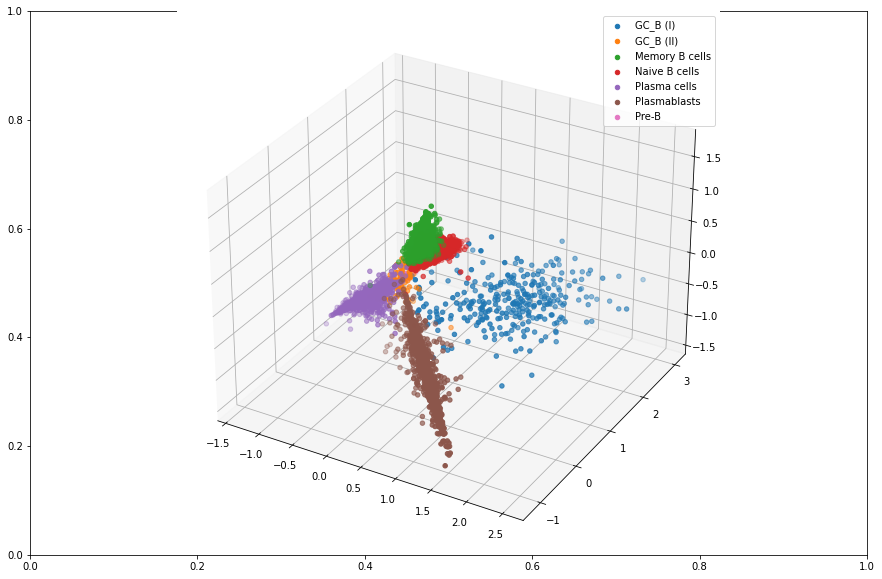

In [ ]:
# Training
training_embeddings = results.get('training_embeddings')
training_embeddings_labels = results.get('training_labels')
if type(training_embeddings[0]) != np.ndarray:
    for i in range(len(training_embeddings_labels)):
            training_embeddings[i] = training_embeddings[i].detach().cpu().numpy()
            training_embeddings_labels[i] = training_embeddings_labels[i].cpu()
training_embeddings_labels=encoder_celltype.inverse_transform(training_embeddings_labels)
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = fig.add_subplot(projection='3d')
    for color in np.unique(np.array(training_embeddings_labels)):
    # for color in ["Memory B cells", "Naive B cells"]:
        i = np.where(training_embeddings_labels == color)
        ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1],np.array(training_embeddings)[i,2], label=color)
    ax.legend()
    plt.show()

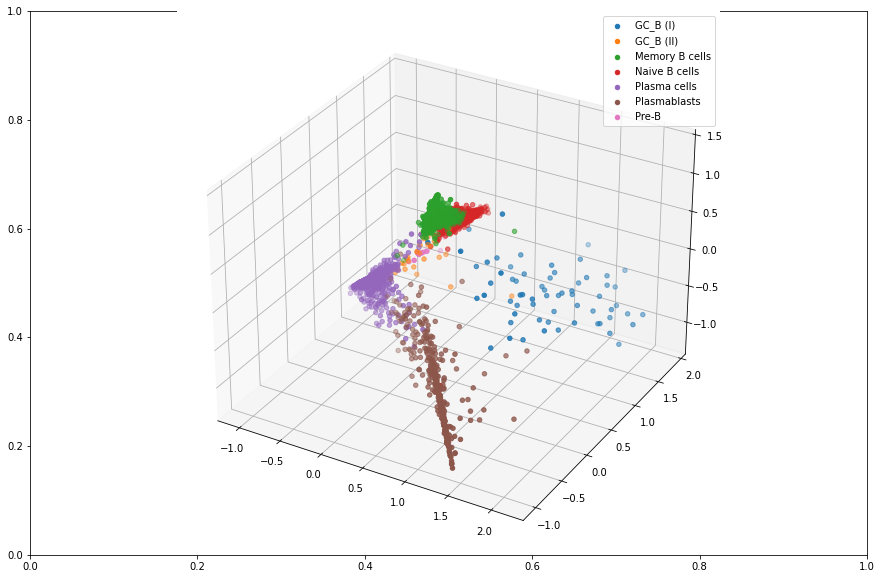

In [ ]:
# Testing
test_embeddings = results.get('test_embeddings')
test_true_labels = results.get('test_true_labels')
if type(test_embeddings[0]) != np.ndarray:
    for i in range(len(test_embeddings)):
        test_embeddings[i] = test_embeddings[i].cpu().numpy()
        test_true_labels[i] = test_true_labels[i].cpu()
test_true_labels=encoder_celltype.inverse_transform(test_true_labels)
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = fig.add_subplot(projection='3d')
    for color in np.unique(np.array(test_true_labels)):
        i = np.where(test_true_labels == color)
        ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1],np.array(test_embeddings)[i,2], label=color)
    ax.legend()
    plt.show()

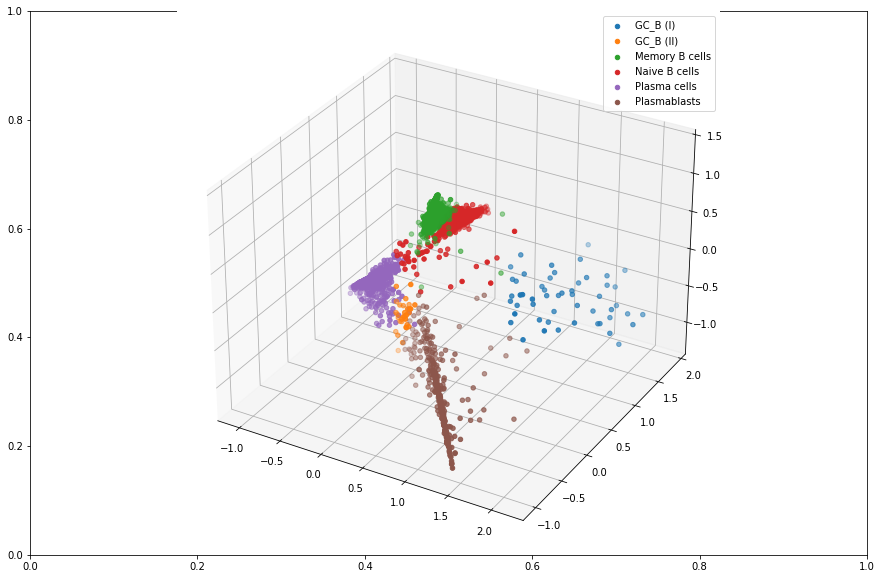

In [ ]:
# Testing pred labels
test_embeddings = results.get('test_embeddings')
test_pred_labels = results.get('test_pred_labels').copy()
for i in range(len(test_pred_labels)):
    test_pred_labels[i] = test_pred_labels[i].argmax()

test_pred_labels=encoder_celltype.inverse_transform(test_pred_labels)
if plot_embedding_space:
    fig, ax = plt.subplots(figsize=(15, 10))
    ax = fig.add_subplot(projection='3d')
    for color in np.unique(np.array(test_pred_labels)):
        i = np.where(test_pred_labels == color)
        ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], np.array(test_embeddings)[i,2], label=color)
    ax.legend()
    plt.show()

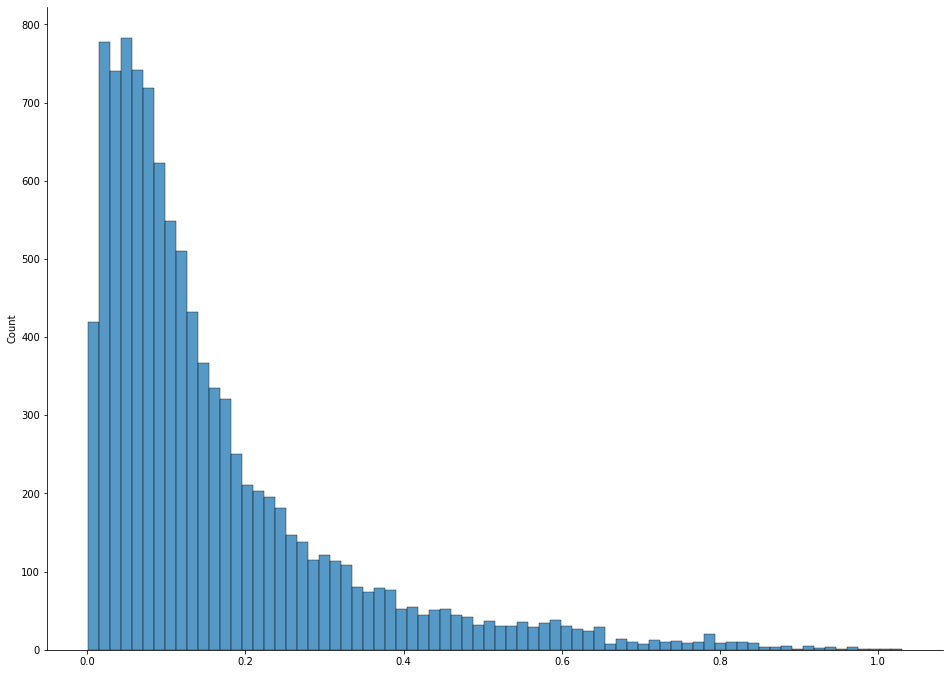

In [ ]:
test_pred_dists = results.get('test_pred_labels').copy()
test_pred_labels = encoder_celltype.fit_transform(test_pred_labels)
test_true_labels = encoder_celltype.fit_transform(test_true_labels)
true_pos = []
for i in range(len(test_pred_dists)):
    test_pred_dists[i] = -test_pred_dists[i][test_pred_labels[i]]
    if test_pred_labels[i] == test_true_labels[i]:
        true_pos.append(test_pred_dists[i])

g = sns.displot(test_pred_dists)
g.fig.set_size_inches(15,10)

c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


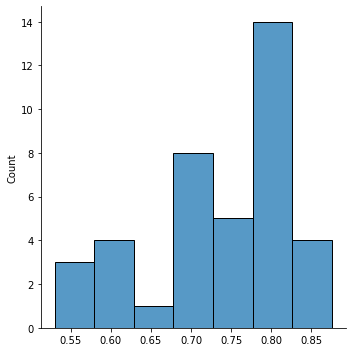

In [ ]:
dataset_Pro_B=dataset_Pro_B[:, dataset.var_names]
sc.pp.normalize_total(dataset_Pro_B, target_sum = 1e4)
sc.pp.log1p(dataset_Pro_B)
dataset_Pro_B = AnnLoader(dataset_Pro_B, batch_size=512)
for batch in dataset_Pro_B:
    x = batch.X.cuda()
    model = results.get('model')
    with torch.no_grad():
        out_Pro_B, embedding_Pro_B = model(x)
    pred = out_Pro_B.detach()
Pro_B_pred = pred.cpu().numpy()
for i in range(len(Pro_B_pred)):
    Pro_B_pred[i] = -Pro_B_pred[i].max()
Pro_B_pred = Pro_B_pred[:, 0]
g = sns.displot(Pro_B_pred)
g.fig.set_size_inches(5,5)

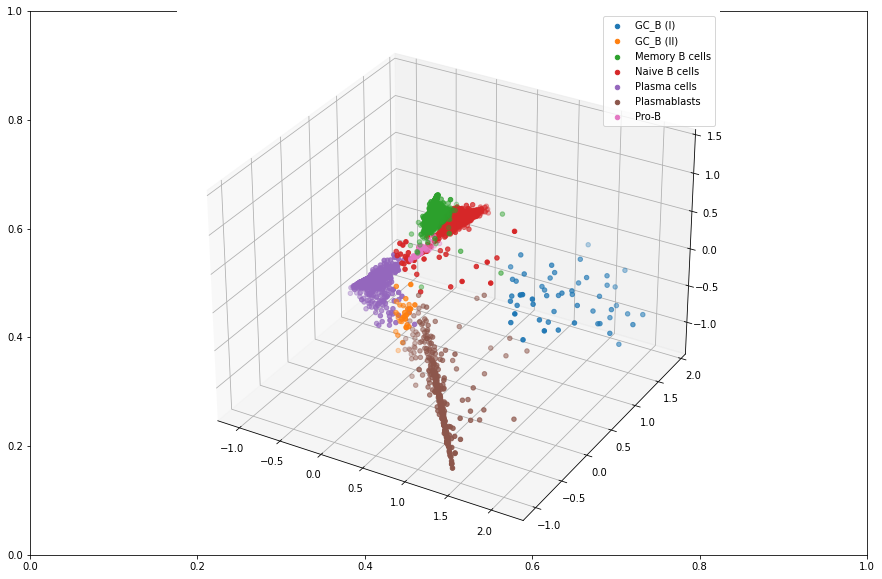

In [ ]:
if type(embedding_Pro_B) != np.ndarray:
    embedding_Pro_B = embedding_Pro_B.cpu().numpy()
    test_pred_labels = encoder_celltype.inverse_transform(test_pred_labels)
fig, ax = plt.subplots(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')
for color in np.unique(np.array(test_pred_labels)):
    i = np.where(test_pred_labels == color)
    ax.scatter(np.array(test_embeddings)[i,0], np.array(test_embeddings)[i,1], np.array(test_embeddings)[i,2], label=color)
    
ax.scatter(np.array(embedding_Pro_B)[:,0], np.array(embedding_Pro_B)[:,1], np.array(embedding_Pro_B)[:,2], label='Pro-B')
ax.legend()
plt.show()